In [1]:
import numpy as np
import skimage 
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage.io import imread, imshow
import seaborn as sns

from matplotlib.pyplot import figure

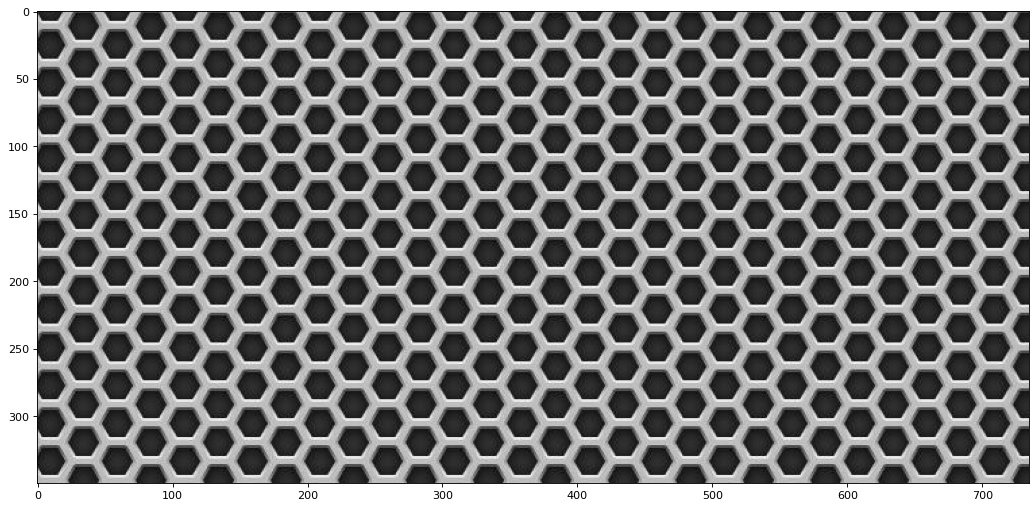

In [56]:
figure(figsize=(16, 12), dpi=80)
img = cv.imread('metalgrid.jpg', cv.IMREAD_GRAYSCALE)
plt.imshow(img,cmap='gray')
plt.show()

In [57]:
img.shape

(350, 735)

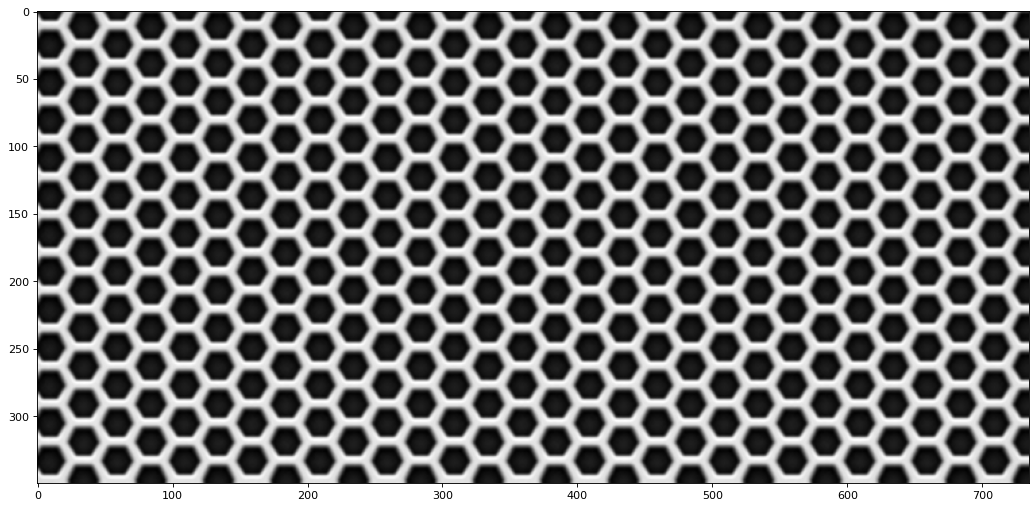

In [58]:
# Elimino el ruido aplicando filtro gausiano:
figure(figsize=(16, 12), dpi=80)
blur = cv.GaussianBlur(img,(5,5),0)
plt.imshow(blur,cmap='gray')
plt.show()

In [116]:
# Aplicamos Sobelx en 'float32' y luego convertimos de nuevo a 8-bit para evitar overflow
sobelx_64 = cv.Sobel(blur,cv.CV_32F,1,0,ksize=3) # Buscamos el valor de G en la componente x.
absx_64 = np.absolute(sobelx_64) # Obtenemos el valor absoluto.
sobelx_8u1 = absx_64/absx_64.max()*255  # Se reescala a 8 bit.
sobelx_8u = np.uint8(sobelx_8u1) # se convierte el tipo de dato.

# De igual modo para Sobely
sobely_64 = cv.Sobel(blur,cv.CV_32F,0,1,ksize=3)
absy_64 = np.absolute(sobely_64)
sobely_8u1 = absy_64/absy_64.max()*255
sobely_8u = np.uint8(sobely_8u1)

# De los gradiente calculamos Magnitud y lo pasamos a 8-bit (Opcional)
mag = np.hypot(sobelx_8u, sobely_8u)
mag = mag/mag.max()*255 
mag = np.uint8(mag)

In [117]:
# Encontramos la Dirección y la pasamos a grados
theta = np.arctan2(sobely_64, sobelx_64)
angle = np.rad2deg(theta)

In [118]:
M, N = mag.shape
Non_max = np.zeros((M,N), dtype= np.uint8)

for i in range(1,M-1):
    for j in range(1,N-1):
       # Horizontal 0
        if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180) or (-22.5 <= angle[i,j] < 0) or (-180 <= angle[i,j] < -157.5):
            b = mag[i, j+1]
            c = mag[i, j-1]
        # Diagonal 45
        elif (22.5 <= angle[i,j] < 67.5) or (-157.5 <= angle[i,j] < -112.5):
            b = mag[i+1, j+1]
            c = mag[i-1, j-1]
        # Vertical 90
        elif (67.5 <= angle[i,j] < 112.5) or (-112.5 <= angle[i,j] < -67.5):
            b = mag[i+1, j]
            c = mag[i-1, j]
        # Diagonal 135
        elif (112.5 <= angle[i,j] < 157.5) or (-67.5 <= angle[i,j] < -22.5):
            b = mag[i+1, j-1]
            c = mag[i-1, j+1]           
            
        # Supresión de no-máximos
        if (mag[i,j] >= b) and (mag[i,j] >= c):
            Non_max[i,j] = mag[i,j]
        else:
            Non_max[i,j] = 0


            

# Umbralizado por histéresis
#===========================


UmbralAlto = 35
UmbralBajo = 20

M, N = Non_max.shape
out = np.zeros((M,N), dtype= np.uint8)

# Si la intensidad de un borde es mayor a 'UmbralAlto' es seguro un umbral, debajo de 'UmbralBajo' seguro no es
strong_i, strong_j = np.where(Non_max >= UmbralAlto)
zeros_i, zeros_j = np.where(Non_max < UmbralBajo)

# Bordes débiles
weak_i, weak_j = np.where((Non_max <= UmbralAlto) & (Non_max >= UmbralBajo))

# Setear el mismo valor a todos los tipos de píxel
out[strong_i, strong_j] = 255
out[zeros_i, zeros_j ] = 0
out[weak_i, weak_j] = 75


# Armo la imagen de bordes
#=========================
M, N = out.shape
for i in range(1, M-1):
    for j in range(1, N-1):
        if (out[i,j] == 75):
            if 255 in [out[i+1, j-1],out[i+1, j],out[i+1, j+1],out[i, j-1],out[i, j+1],out[i-1, j-1],out[i-1, j],out[i-1, j+1]]:
                out[i, j] = 255
            else:
                out[i, j] = 0

In [119]:
mask = mag > 150
angle = angle * mask

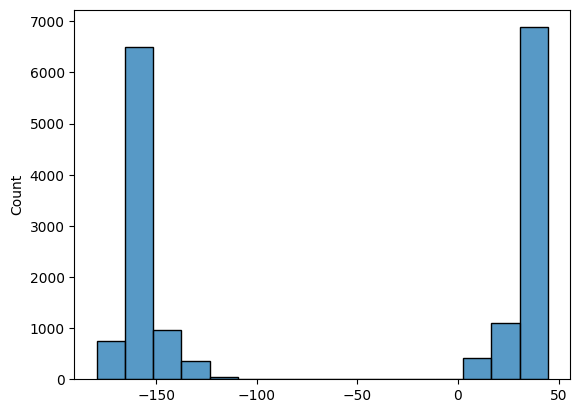

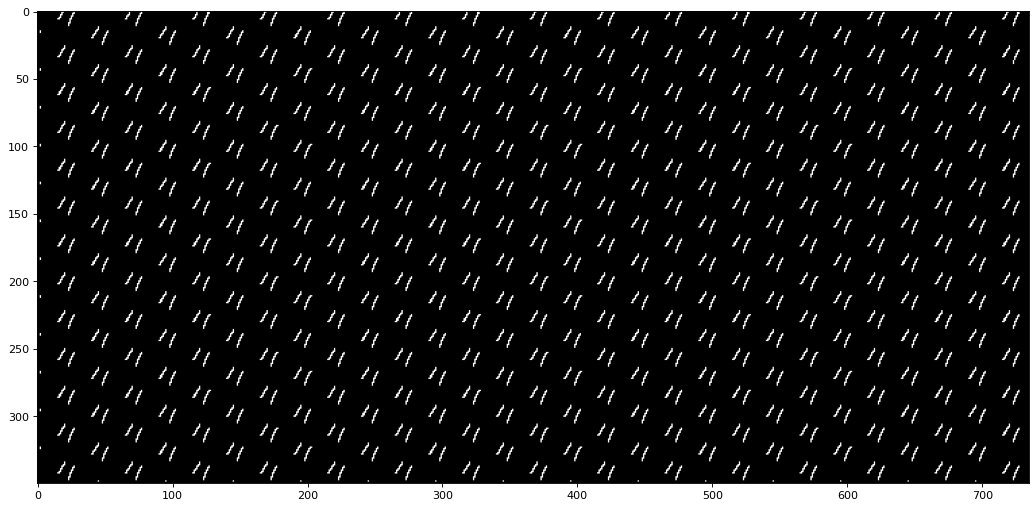

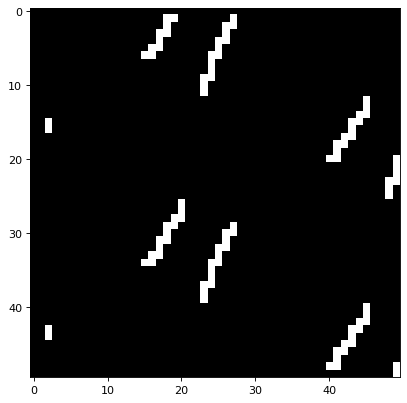

In [120]:
#Creo primera mascara:

sns.histplot( angle[(angle > 0) & (angle < 45) | (angle < -120)] )

angulos_1 = (angle > 0) & (angle < 45) | (angle < -120)
resul_1 = angulos_1 * out
figure(figsize=(16, 12), dpi=80)
plt.imshow(resul_1,cmap='gray')

figure(figsize=(8, 6), dpi=80)
plt.imshow(resul_1[0:50,0:50],cmap='gray')
plt.show()



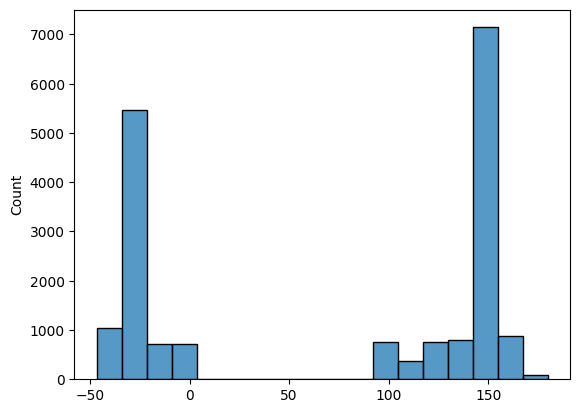

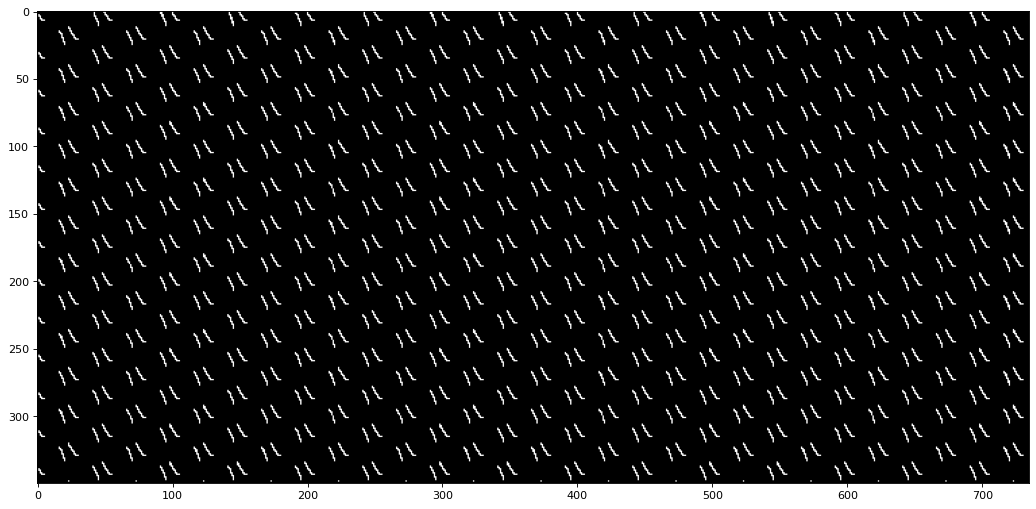

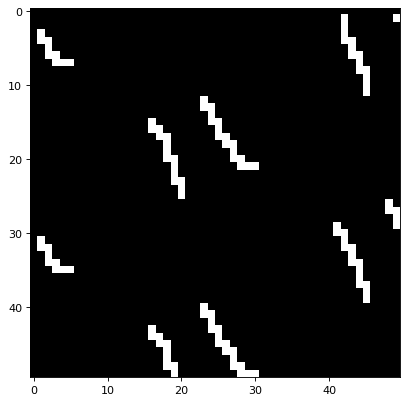

In [121]:
sns.histplot( angle[ (angle > 95) | ((angle < 0) & (angle > -50))] )

angulos_2 = (angle > 95) | ((angle < 0) & (angle > -50))

resul_2 = angulos_2 * out
figure(figsize=(16, 12), dpi=80)
plt.imshow(resul_2,cmap='gray')

figure(figsize=(8, 6), dpi=80)
plt.imshow(resul_2[0:50,0:50],cmap='gray')

plt.show()

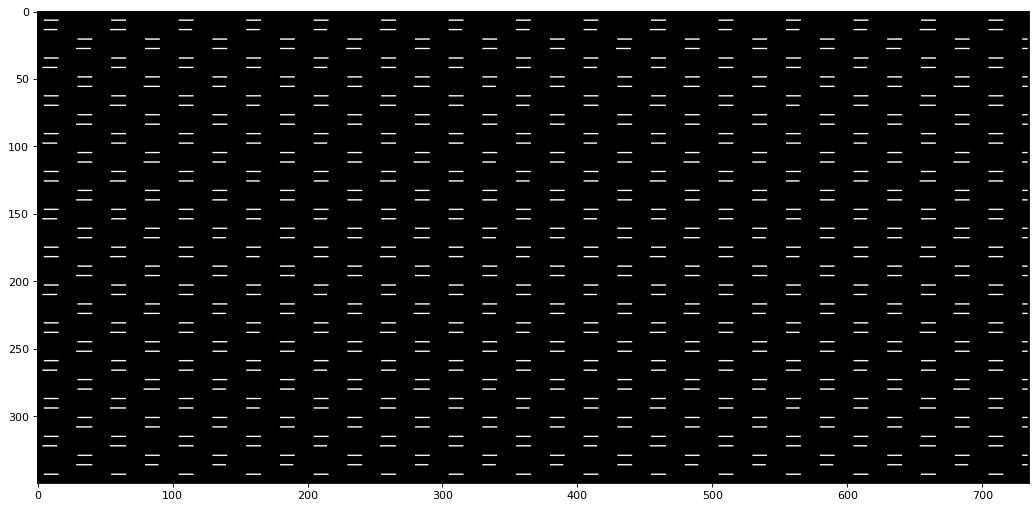

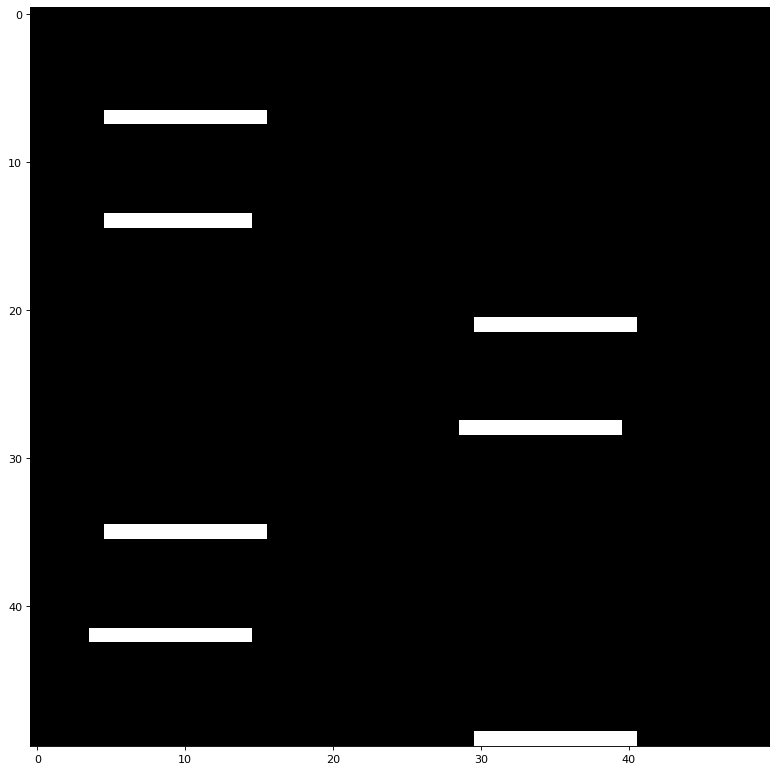

In [122]:
angulos_3 = ((angle < -50) & (angle > -100)) | ((angle > 50) & (angle < 100))

resul_3 = angulos_3 * out
figure(figsize=(16, 12), dpi=80)
plt.imshow(resul_3,cmap='gray')

figure(figsize=(16, 12), dpi=80)
plt.imshow(resul_3[0:50,0:50],cmap='gray')

plt.show()

In [123]:
img_new = cv.imread('metalgrid.jpg')

In [124]:
#Creao las mascaras
resul_mask_1 = resul_1 != 0
resul_mask_2 = resul_2 != 0
resul_mask_3 = resul_3 != 0

In [125]:
# Asigno los colores por mascara.
img_new[:,:,0][resul_mask_1] = 255
img_new[:,:,1][resul_mask_1] = 0
img_new[:,:,2][resul_mask_1] = 0

img_new[:,:,0][resul_mask_2] = 0
img_new[:,:,1][resul_mask_2] = 0
img_new[:,:,2][resul_mask_2] = 255

img_new[:,:,0][resul_mask_3] = 0
img_new[:,:,1][resul_mask_3] = 255
img_new[:,:,2][resul_mask_3] = 0

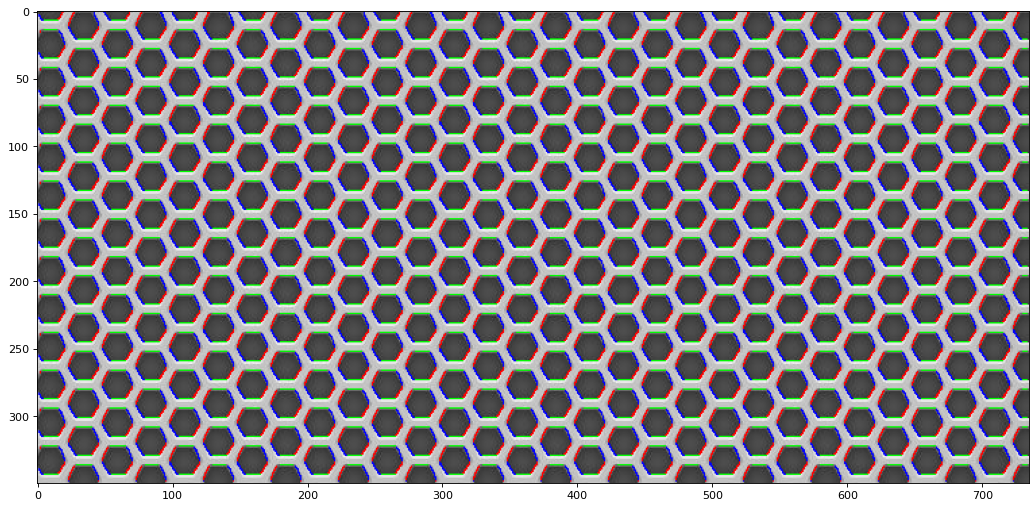

In [126]:
figure(figsize=(16, 12), dpi=80)
plt.imshow(img_new)
plt.show()

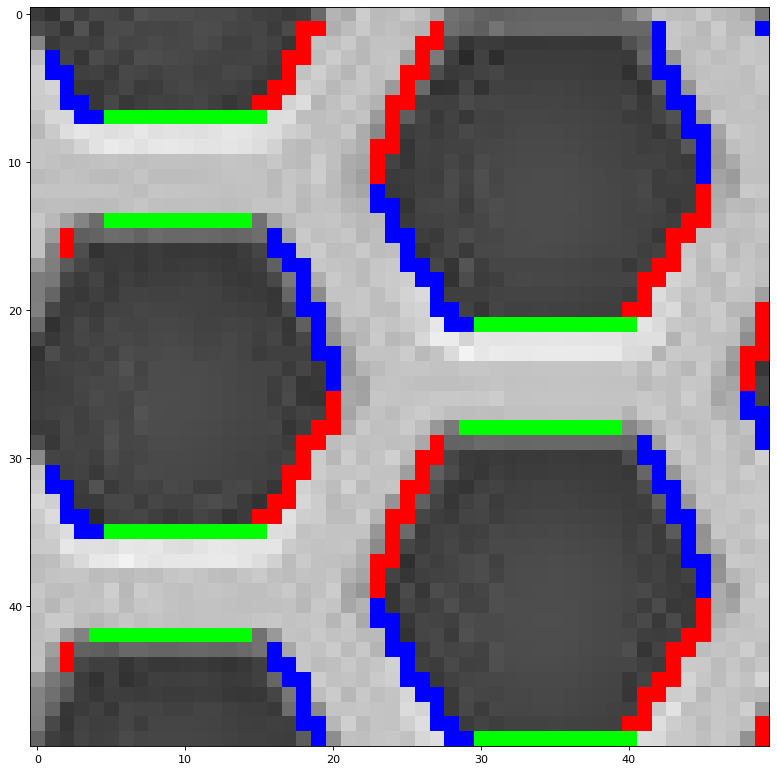

In [127]:
figure(figsize=(16, 12), dpi=80)
plt.imshow(img_new[0:50,0:50], "BrBG")
plt.show()